In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense, AveragePooling2D
from keras import applications
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data/512/train/'
test_dir = 'data/512/test/'
test_dir_whithout_aug = "data/512/test-without-aug/"

extracted_features_dir = "extracted_features/"
model_name = "Xception_512_Adam1_50_epoch"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/512/train/ 0
data/512/train/Benign 1152
data/512/train/InSitu 1152
data/512/train/Invasive 1152
data/512/train/Normal 1152
******************************
data/512/test/ 0
data/512/test/Benign 448
data/512/test/InSitu 448
data/512/test/Invasive 448
data/512/test/Normal 448


In [5]:
output_classes = 4
batch_size = 32
img_height, img_width = 512, 384
input_shape = (img_height, img_width, 3)
epochs = 50

top_model_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_weights.h5')

nb_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
nb_test_samples = sum([len(files) for r, d, files in os.walk(test_dir)])

print("train samples:", nb_train_samples)
print("test samples:", nb_test_samples)

train samples: 4608
test samples: 1792


In [6]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

test_generator_without_aug = test_datagen.flow_from_directory(
    test_dir_whithout_aug,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 3456 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.
Found 1792 images belonging to 4 classes.
Found 112 images belonging to 4 classes.


In [7]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)

nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

print("nb_test_samples:", nb_test_without_aug_samples)
print("predict_size_test:", predict_size_test_without_aug)

print("\n num_classes:", num_classes)

nb_train_samples: 3456
nb_validation_samples: 1152

predict_size_train: 108
predict_size_validation: 36
nb_test_samples: 112
predict_size_test: 4

 num_classes: 4


In [8]:
nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

nb_test_samples: 1792
predict_size_test: 56


In [9]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_Xception_512.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_Xception_512.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_Xception_512.npy')
test_data_without_aug = np.load(extracted_features_dir+'bottleneck_features_test_without_aug_Xception_512.npy')


train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)


test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

test_labels_without_aug = test_generator_without_aug.classes
test_labels_without_aug = to_categorical(test_labels_without_aug, num_classes=num_classes)

In [11]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation='softmax'))


adam_opt1=Adam(lr = 0.001, beta_1=0.8, beta_2=0.7, amsgrad=True)

model.compile(optimizer=adam_opt1, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 3456 samples, validate on 1152 samples
Epoch 1/50
 - 3s - loss: 0.8352 - acc: 0.6693 - val_loss: 0.5806 - val_acc: 0.7856
Epoch 2/50
 - 0s - loss: 0.5384 - acc: 0.8056 - val_loss: 0.4433 - val_acc: 0.8542
Epoch 3/50
 - 0s - loss: 0.4032 - acc: 0.8663 - val_loss: 0.3622 - val_acc: 0.8741
Epoch 4/50
 - 0s - loss: 0.3339 - acc: 0.8921 - val_loss: 0.3052 - val_acc: 0.8993
Epoch 5/50
 - 0s - loss: 0.2764 - acc: 0.9123 - val_loss: 0.2731 - val_acc: 0.9028
Epoch 6/50
 - 0s - loss: 0.2326 - acc: 0.9346 - val_loss: 0.2284 - val_acc: 0.9332
Epoch 7/50
 - 0s - loss: 0.2047 - acc: 0.9473 - val_loss: 0.2304 - val_acc: 0.9236
Epoch 8/50
 - 0s - loss: 0.1724 - acc: 0.9554 - val_loss: 0.1934 - val_acc: 0.9297
Epoch 9/50
 - 0s - loss: 0.1507 - acc: 0.9659 - val_loss: 0.1805 - val_acc: 0.9384
Epoch 10/50
 - 0s - loss: 0.1352 - acc: 0.9716 - val_loss: 0.1623 - val_acc: 0.9505
Epoch 11/50
 - 0s - loss: 0.1240 - acc: 0.9705 - val_loss: 0.1515 - val_acc: 0.9549
Epoch 12/50
 - 0s - loss: 0.1125 - ac

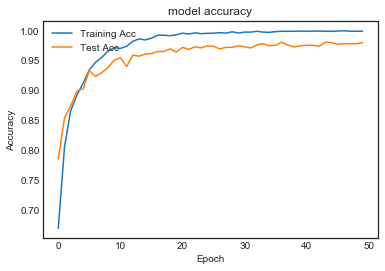

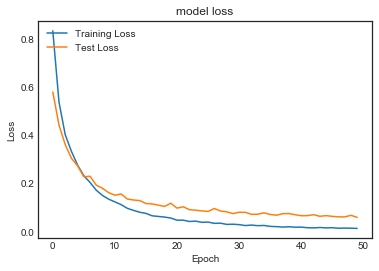

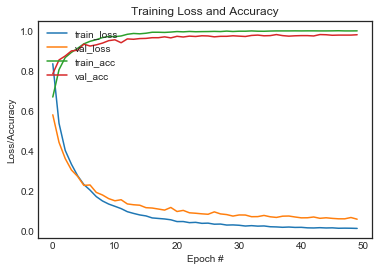

In [12]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [13]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

1152/1152 [==============================] - 0s 49us/step
Validation Accuracy: 98.0035%
Validation Loss: 0.059613298210832805


# Test augmented

In [14]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.859375


Confusion Matrix
[[366  58  16   8]
 [ 36 379  14  19]
 [ 21  41 384   2]
 [ 27   8   2 411]]


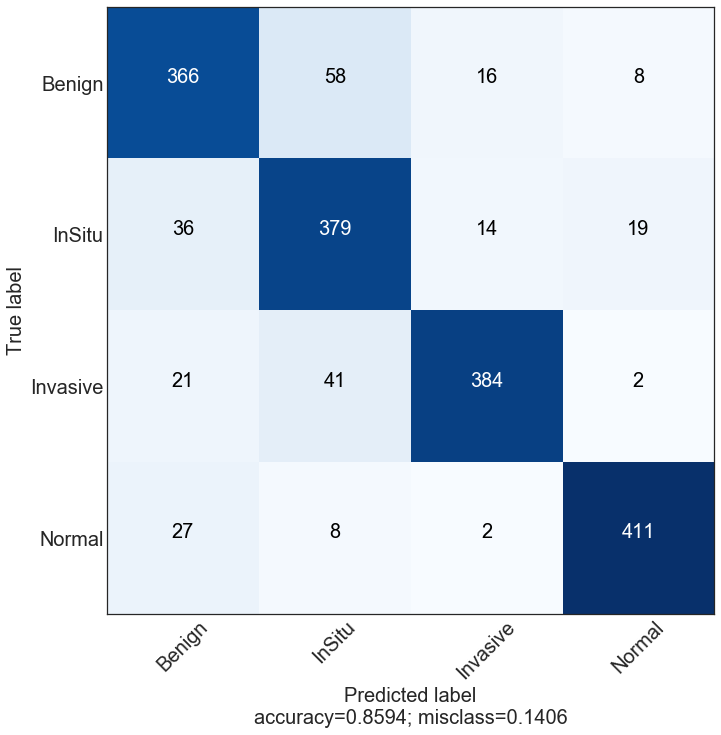

In [15]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[366  58  16   8]
 [ 36 379  14  19]
 [ 21  41 384   2]
 [ 27   8   2 411]]
              precision    recall  f1-score   support

    Invasive       0.81      0.82      0.82       448
      Normal       0.78      0.85      0.81       448
      Benign       0.92      0.86      0.89       448
      InSitu       0.93      0.92      0.93       448

   micro avg       0.86      0.86      0.86      1792
   macro avg       0.86      0.86      0.86      1792
weighted avg       0.86      0.86      0.86      1792



In [17]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  91.04477611940298
Specificity :  86.72768878718536


____
# test without augmentation

In [18]:
preds = model.predict(test_data_without_aug)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels_without_aug]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8392857142857143


Confusion Matrix
[[21  5  1  1]
 [ 2 22  1  3]
 [ 2  2 24  0]
 [ 1  0  0 27]]


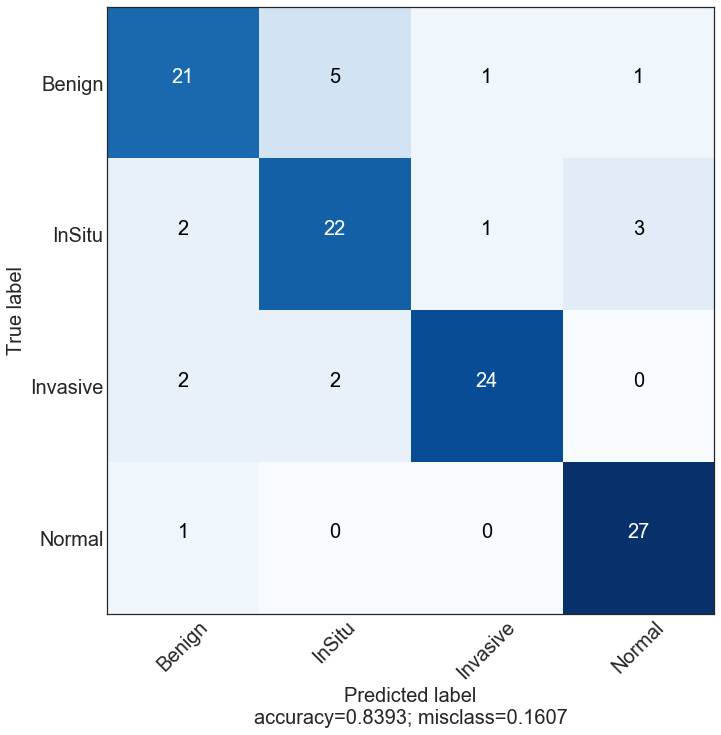

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator_without_aug.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator_without_aug.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[21  5  1  1]
 [ 2 22  1  3]
 [ 2  2 24  0]
 [ 1  0  0 27]]
              precision    recall  f1-score   support

    Invasive       0.81      0.75      0.78        28
      Normal       0.76      0.79      0.77        28
      Benign       0.92      0.86      0.89        28
      InSitu       0.87      0.96      0.92        28

   micro avg       0.84      0.84      0.84       112
   macro avg       0.84      0.84      0.84       112
weighted avg       0.84      0.84      0.84       112



In [21]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  91.30434782608695
Specificity :  81.48148148148148
